# Phase 5: Autoencoder Anomaly Detection

This notebook trains an autoencoder to detect anomalous/unusual waste items.
The autoencoder learns to reconstruct normal waste images, and items with high reconstruction error are flagged as anomalies.

## 1. Setup and Imports

In [2]:
import os
import sys
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import yaml
from tqdm import tqdm

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set project root
PROJECT_ROOT = Path(r"c:/Users/anike/Downloads/WasteSegregation")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project Root: {PROJECT_ROOT}")
print(f"TensorFlow Version: {tf.__version__}")
print("\n✅ Imports successful!")

Project Root: c:\Users\anike\Downloads\WasteSegregation
TensorFlow Version: 2.20.0

✅ Imports successful!


In [3]:
# Load configuration
config_path = PROJECT_ROOT / "config" / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Define paths
PROCESSED_DATA_PATH = PROJECT_ROOT / "datasets" / "processed"
MODELS_PATH = PROJECT_ROOT / "models" / "autoencoder"
MODELS_PATH.mkdir(parents=True, exist_ok=True)

# Autoencoder configuration
AE_CONFIG = config['autoencoder']

# Image settings - smaller size for autoencoder
IMG_SIZE = (AE_CONFIG['input_shape'][0], AE_CONFIG['input_shape'][1])  # 128x128
ENCODING_DIM = AE_CONFIG['encoding_dim']
BATCH_SIZE = AE_CONFIG['batch_size']
EPOCHS = 20  # Reduced for CPU training
ANOMALY_THRESHOLD = AE_CONFIG['anomaly_threshold']

print("📋 Autoencoder Configuration:")
print("=" * 50)
print(f"   Image Size: {IMG_SIZE}")
print(f"   Encoding Dimension: {ENCODING_DIM}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Anomaly Threshold: {ANOMALY_THRESHOLD}")

📋 Autoencoder Configuration:
   Image Size: (128, 128)
   Encoding Dimension: 64
   Batch Size: 32
   Epochs: 20
   Anomaly Threshold: 0.02


## 2. Load and Prepare Data

In [4]:
def load_images_from_directory(directory, img_size, max_images=None):
    """
    Load images from a directory and resize them.
    """
    images = []
    image_paths = []
    
    # Get all jpg files recursively
    all_files = list(Path(directory).rglob("*.jpg"))
    
    if max_images:
        all_files = all_files[:max_images]
    
    for img_path in tqdm(all_files, desc="Loading images"):
        try:
            img = cv2.imread(str(img_path))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype(np.float32) / 255.0
                images.append(img)
                image_paths.append(img_path)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    
    return np.array(images), image_paths


print("📂 Loading training images...")
train_images, train_paths = load_images_from_directory(
    PROCESSED_DATA_PATH / "train" / "classification",
    IMG_SIZE,
    max_images=1500  # Limit for faster training
)

print(f"\n📂 Loading validation images...")
val_images, val_paths = load_images_from_directory(
    PROCESSED_DATA_PATH / "val" / "classification",
    IMG_SIZE,
    max_images=300
)

print(f"\n✅ Data loaded!")
print(f"   Training images: {train_images.shape}")
print(f"   Validation images: {val_images.shape}")

📂 Loading training images...


Loading images: 100%|██████████| 1500/1500 [00:03<00:00, 455.96it/s]



📂 Loading validation images...


Loading images: 100%|██████████| 300/300 [00:00<00:00, 560.20it/s]


✅ Data loaded!
   Training images: (1500, 128, 128, 3)
   Validation images: (300, 128, 128, 3)


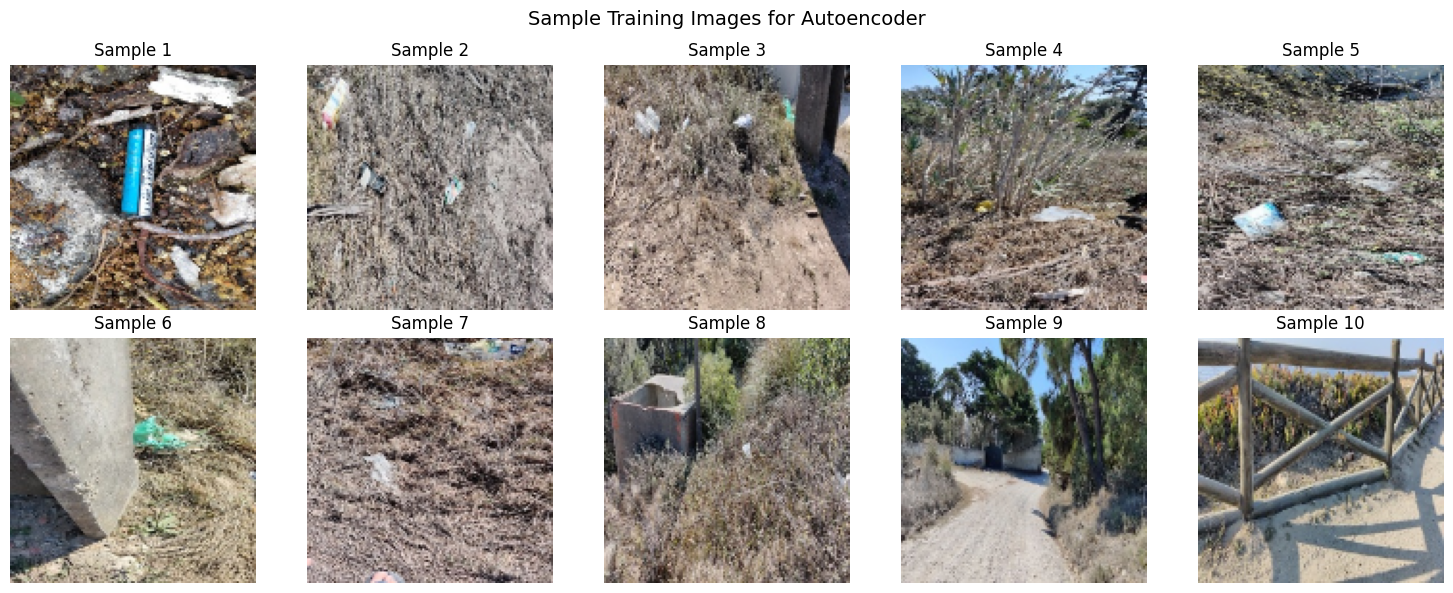

In [5]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(train_images):
        ax.imshow(train_images[i])
        ax.axis('off')
        ax.set_title(f"Sample {i+1}")

plt.suptitle('Sample Training Images for Autoencoder', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Build Autoencoder Model

In [6]:
def build_autoencoder(input_shape, encoding_dim):
    """
    Build a convolutional autoencoder for anomaly detection.
    
    Architecture:
    - Encoder: Conv2D layers to compress image
    - Bottleneck: Dense layer with encoding_dim neurons
    - Decoder: Conv2DTranspose layers to reconstruct image
    """
    # Input
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck - handle both TensorShape and tuple
    shape_info = encoded.shape[1:]
    if hasattr(shape_info, 'as_list'):
        shape_before_flatten = tuple(shape_info.as_list())
    else:
        shape_before_flatten = tuple(shape_info)
    flatten_size = int(np.prod(shape_before_flatten))
    
    x = layers.Flatten()(encoded)
    x = layers.Dense(encoding_dim, activation='relu', name='encoding')(x)
    x = layers.Dense(flatten_size, activation='relu')(x)
    x = layers.Reshape(shape_before_flatten)(x)
    
    # Decoder
    x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    # Output
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Full autoencoder
    autoencoder = Model(inputs, decoded, name='autoencoder')
    
    # Encoder model (for getting encodings)
    encoder = Model(inputs, x, name='encoder')
    
    return autoencoder, encoder


# Build model
print("🔄 Building Autoencoder model...")
input_shape = (*IMG_SIZE, 3)
autoencoder, encoder = build_autoencoder(input_shape, ENCODING_DIM)

# Compile
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

print("\n✅ Autoencoder created!")
autoencoder.summary()

🔄 Building Autoencoder model...

✅ Autoencoder created!


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoding (Dense)                │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16384)          │     1,064,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,480,259 (13.28 MB)

 Trainable params: 3,480,259 (13.28 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Train Autoencoder

In [7]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        str(MODELS_PATH / 'autoencoder_best.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

print("📋 Training Callbacks:")
print("   • EarlyStopping (patience=5)")
print("   • ModelCheckpoint (save best)")
print("   • ReduceLROnPlateau (factor=0.5)")

📋 Training Callbacks:
   • EarlyStopping (patience=5)
   • ModelCheckpoint (save best)
   • ReduceLROnPlateau (factor=0.5)


In [8]:
# Train autoencoder
print("🚀 Training Autoencoder...")
print("=" * 50)
print(f"⏳ Training for up to {EPOCHS} epochs...")
print("=" * 50 + "\n")

history = autoencoder.fit(
    train_images, train_images,  # Input = Output for autoencoder
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images, val_images),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 50)
print("✅ Training complete!")
print("=" * 50)

🚀 Training Autoencoder...
⏳ Training for up to 20 epochs...

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0535
Epoch 1: val_loss improved from None to 0.03290, saving model to c:\Users\anike\Downloads\WasteSegregation\models\autoencoder\autoencoder_best.keras

Epoch 1: finished saving model to c:\Users\anike\Downloads\WasteSegregation\models\autoencoder\autoencoder_best.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - loss: 0.0455 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0322
Epoch 2: val_loss improved from 0.03290 to 0.02454, saving model to c:\Users\anike\Downloads\WasteSegregation\models\autoencoder\autoencoder_best.keras

Epoch 2: finished saving model to c:\Users\anike\Downloads\WasteSegregation\models\autoencoder\autoencoder_best.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - loss: 0.0301 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0253
Epoch 3: val

## 5. Evaluate Reconstruction Quality

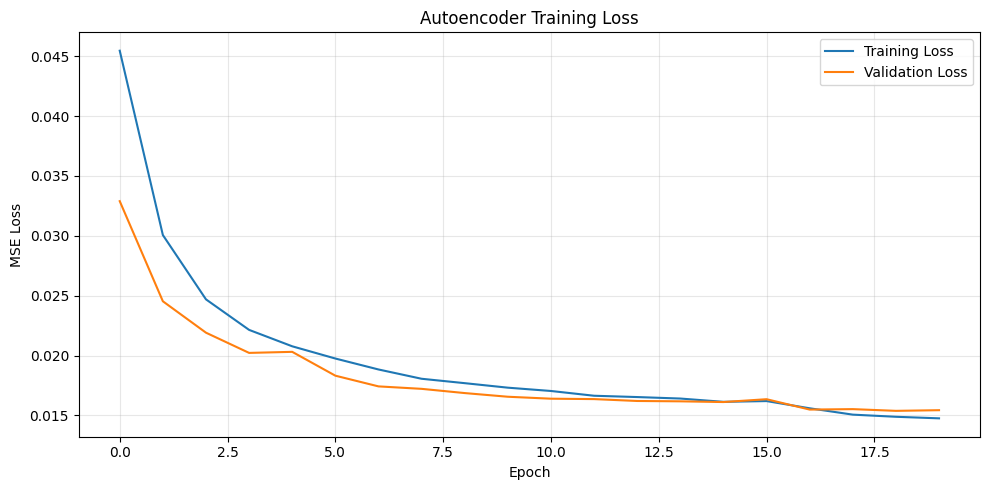

In [9]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

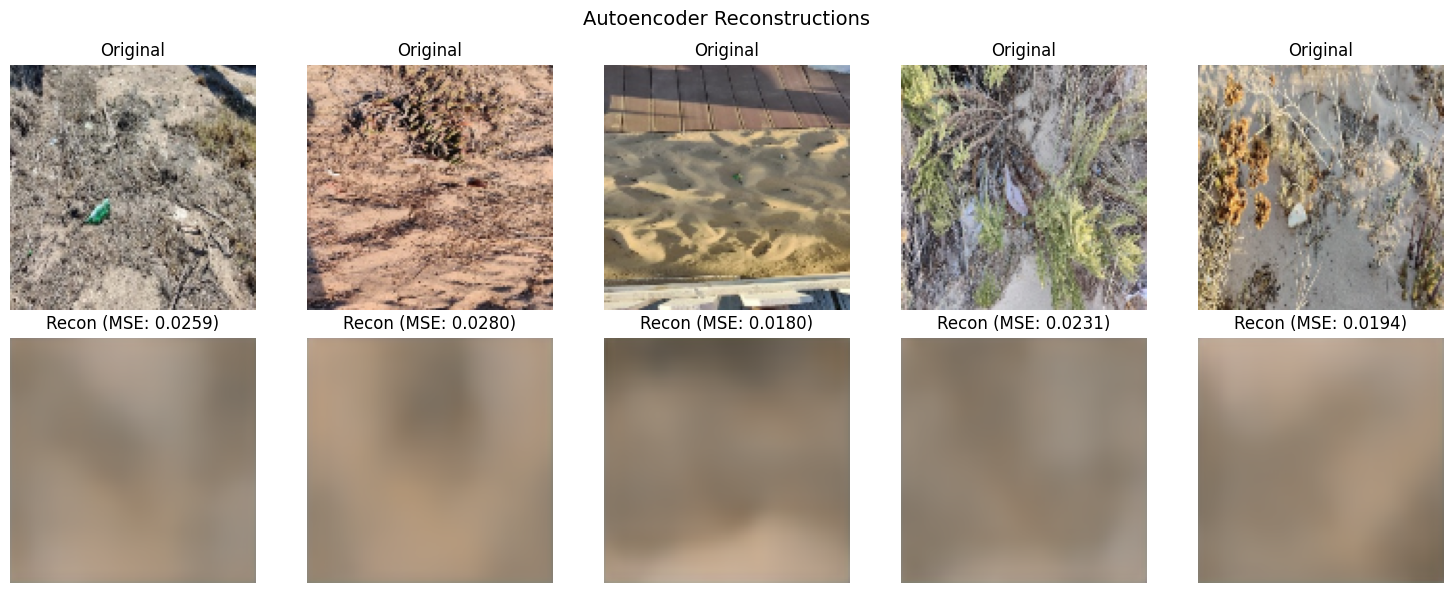

In [10]:
# Visualize reconstructions
def visualize_reconstructions(model, images, n_samples=5):
    """
    Visualize original images and their reconstructions.
    """
    # Get reconstructions
    reconstructed = model.predict(images[:n_samples], verbose=0)
    
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
    
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(images[i])
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Reconstructed
        axes[1, i].imshow(np.clip(reconstructed[i], 0, 1))
        
        # Calculate error
        error = np.mean((images[i] - reconstructed[i]) ** 2)
        axes[1, i].set_title(f'Recon (MSE: {error:.4f})')
        axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel('Original', fontsize=12)
    axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
    
    plt.suptitle('Autoencoder Reconstructions', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_reconstructions(autoencoder, val_images, n_samples=5)

## 6. Calculate Reconstruction Errors and Set Threshold

In [11]:
def calculate_reconstruction_error(model, images, batch_size=32):
    """
    Calculate reconstruction error for each image.
    """
    reconstructed = model.predict(images, batch_size=batch_size, verbose=1)
    
    # Calculate MSE for each image
    errors = np.mean((images - reconstructed) ** 2, axis=(1, 2, 3))
    
    return errors, reconstructed


# Calculate errors on training set
print("📊 Calculating reconstruction errors on training set...")
train_errors, _ = calculate_reconstruction_error(autoencoder, train_images)

print(f"\n📈 Training Set Error Statistics:")
print(f"   Mean Error: {np.mean(train_errors):.6f}")
print(f"   Std Error: {np.std(train_errors):.6f}")
print(f"   Min Error: {np.min(train_errors):.6f}")
print(f"   Max Error: {np.max(train_errors):.6f}")
print(f"   Median Error: {np.median(train_errors):.6f}")

📊 Calculating reconstruction errors on training set...
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 331ms/step

📈 Training Set Error Statistics:
   Mean Error: 0.014616
   Std Error: 0.010513
   Min Error: 0.000788
   Max Error: 0.069802
   Median Error: 0.011426


🎯 Anomaly Threshold (mean + 2*std): 0.035641


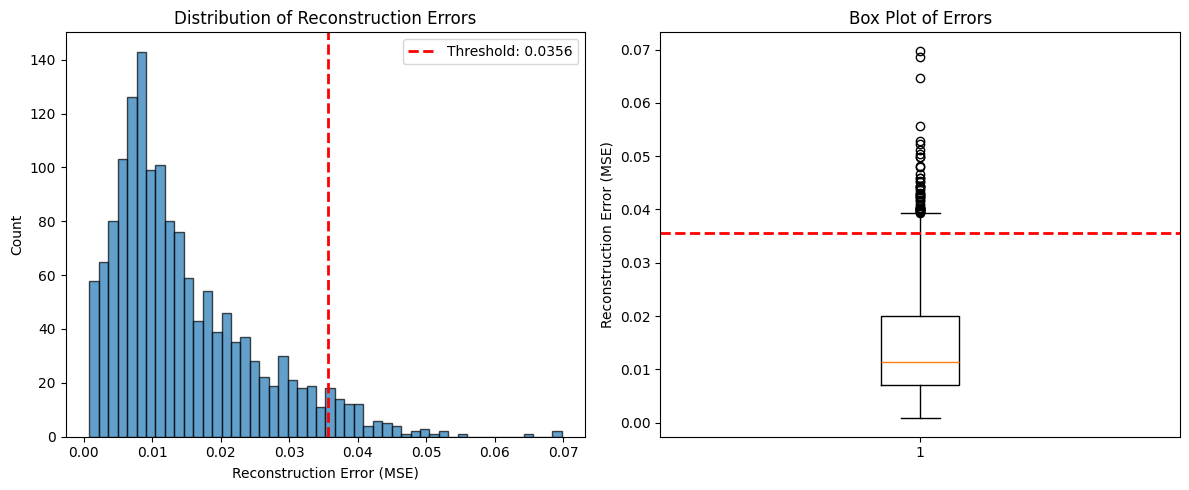

In [12]:
# Determine anomaly threshold
# Use mean + 2*std as threshold (captures ~95% of normal data)
threshold = np.mean(train_errors) + 2 * np.std(train_errors)

print(f"🎯 Anomaly Threshold (mean + 2*std): {threshold:.6f}")

# Plot error distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Errors')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(train_errors)
plt.axhline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Box Plot of Errors')

plt.tight_layout()
plt.show()


🔍 Found 85 potential anomalies in training set (5.7%)


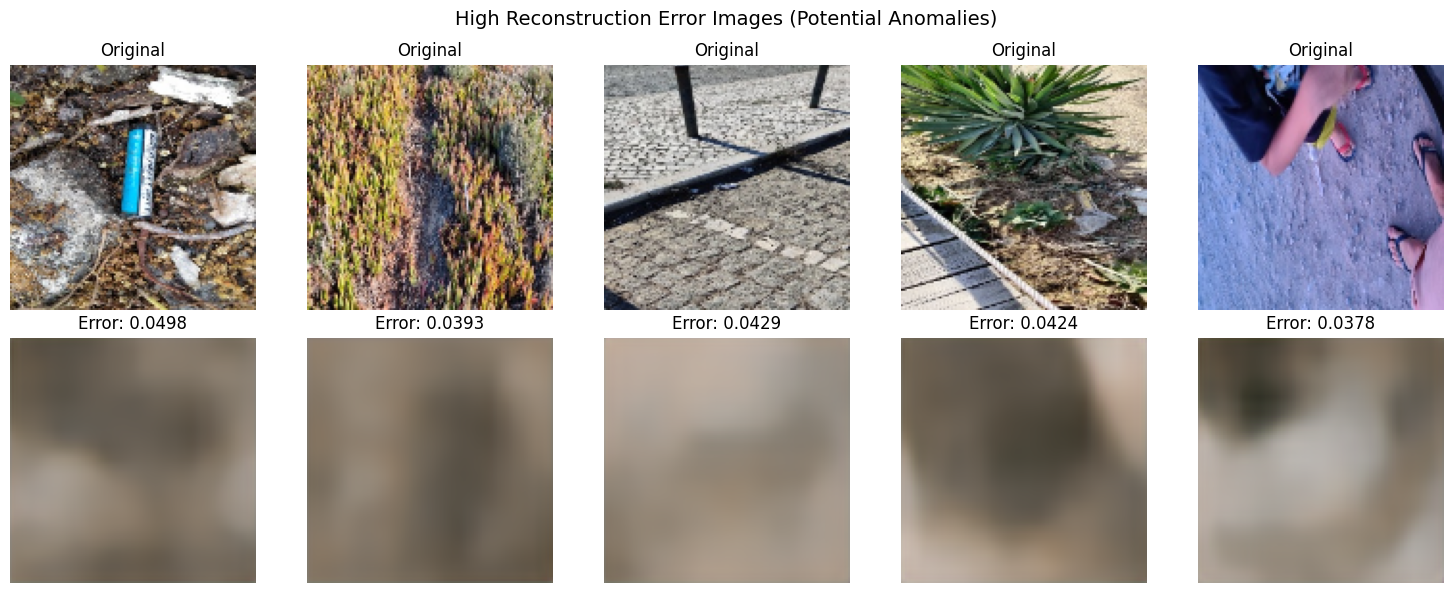

In [13]:
# Find images above threshold (potential anomalies in training set)
anomaly_indices = np.where(train_errors > threshold)[0]

print(f"\n🔍 Found {len(anomaly_indices)} potential anomalies in training set ({len(anomaly_indices)/len(train_errors)*100:.1f}%)")

if len(anomaly_indices) > 0:
    # Visualize some anomalies
    fig, axes = plt.subplots(2, min(5, len(anomaly_indices)), figsize=(15, 6))
    if len(anomaly_indices) == 1:
        axes = axes.reshape(2, 1)
    
    for i, idx in enumerate(anomaly_indices[:5]):
        # Original
        axes[0, i].imshow(train_images[idx])
        axes[0, i].set_title(f'Original')
        axes[0, i].axis('off')
        
        # Reconstructed
        recon = autoencoder.predict(train_images[idx:idx+1], verbose=0)[0]
        axes[1, i].imshow(np.clip(recon, 0, 1))
        axes[1, i].set_title(f'Error: {train_errors[idx]:.4f}')
        axes[1, i].axis('off')
    
    plt.suptitle('High Reconstruction Error Images (Potential Anomalies)', fontsize=14)
    plt.tight_layout()
    plt.show()

## 7. Test Anomaly Detection

In [14]:
# Calculate errors on validation set
print("📊 Testing on validation set...")
val_errors, val_reconstructed = calculate_reconstruction_error(autoencoder, val_images)

# Classify as normal/anomaly
val_predictions = val_errors > threshold
n_anomalies = np.sum(val_predictions)

print(f"\n📈 Validation Set Results:")
print(f"   Total images: {len(val_images)}")
print(f"   Normal: {len(val_images) - n_anomalies} ({(1-n_anomalies/len(val_images))*100:.1f}%)")
print(f"   Anomalies: {n_anomalies} ({n_anomalies/len(val_images)*100:.1f}%)")

📊 Testing on validation set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step

📈 Validation Set Results:
   Total images: 300
   Normal: 285 (95.0%)
   Anomalies: 15 (5.0%)


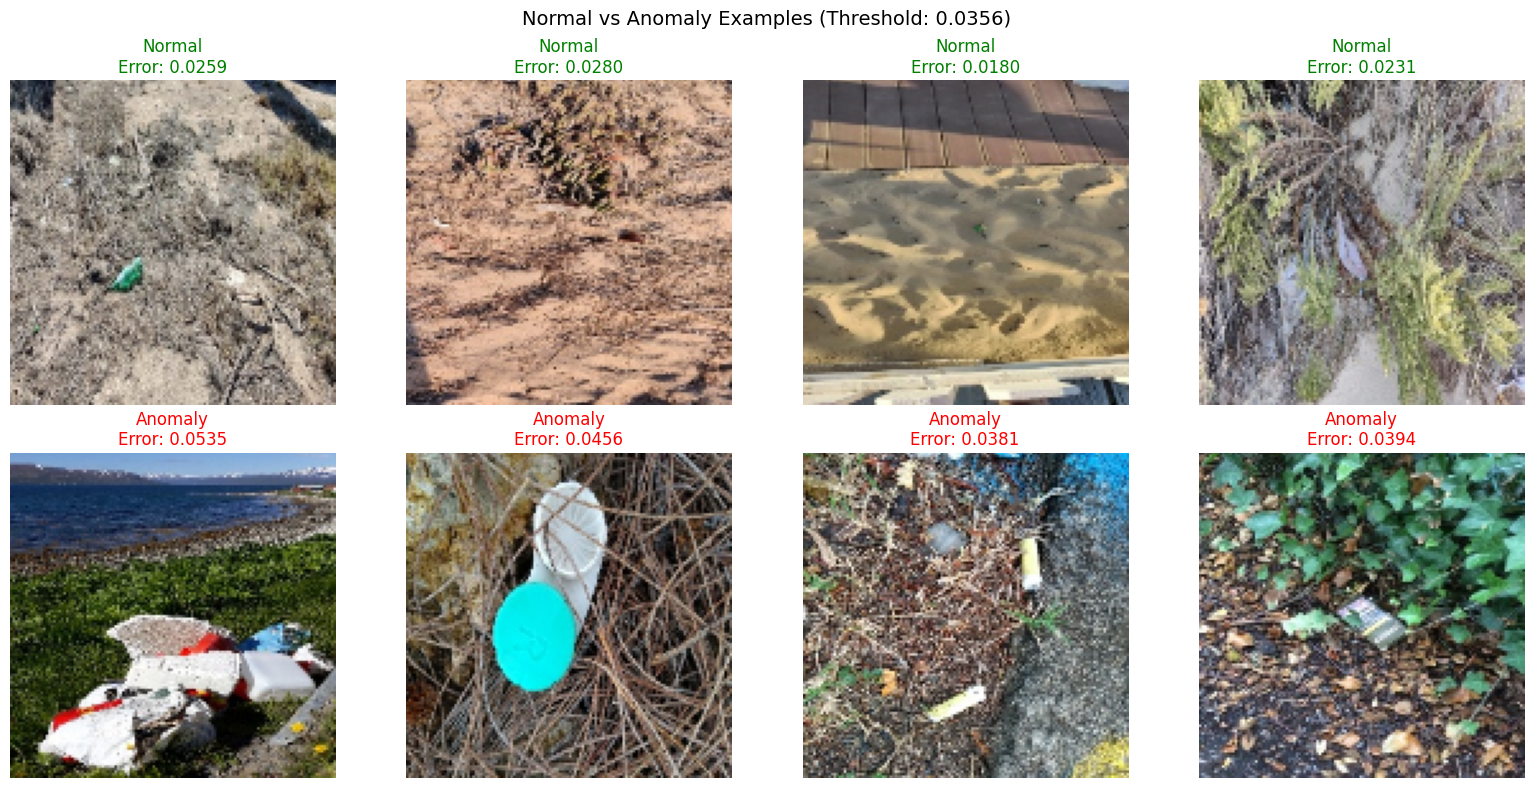

In [15]:
# Visualize normal vs anomaly examples from validation set
normal_indices = np.where(~val_predictions)[0][:4]
anomaly_indices_val = np.where(val_predictions)[0][:4]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Normal examples
for i, idx in enumerate(normal_indices[:4]):
    axes[0, i].imshow(val_images[idx])
    axes[0, i].set_title(f'Normal\nError: {val_errors[idx]:.4f}', color='green')
    axes[0, i].axis('off')

# Anomaly examples
for i, idx in enumerate(anomaly_indices_val[:4]):
    axes[1, i].imshow(val_images[idx])
    axes[1, i].set_title(f'Anomaly\nError: {val_errors[idx]:.4f}', color='red')
    axes[1, i].axis('off')

# Fill remaining if not enough anomalies
for i in range(len(anomaly_indices_val), 4):
    axes[1, i].text(0.5, 0.5, 'No more\nanomalies', ha='center', va='center')
    axes[1, i].axis('off')

plt.suptitle(f'Normal vs Anomaly Examples (Threshold: {threshold:.4f})', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Save Model and Create Utility

In [16]:
# Save model
final_model_path = MODELS_PATH / "autoencoder_final.keras"
autoencoder.save(str(final_model_path))
print(f"✅ Model saved to: {final_model_path}")

# Save threshold
threshold_config = {
    'threshold': float(threshold),
    'mean_error': float(np.mean(train_errors)),
    'std_error': float(np.std(train_errors)),
    'image_size': list(IMG_SIZE),
    'encoding_dim': ENCODING_DIM
}

threshold_path = MODELS_PATH / "anomaly_config.yaml"
with open(threshold_path, 'w') as f:
    yaml.dump(threshold_config, f)
print(f"✅ Threshold config saved to: {threshold_path}")

✅ Model saved to: c:\Users\anike\Downloads\WasteSegregation\models\autoencoder\autoencoder_final.keras
✅ Threshold config saved to: c:\Users\anike\Downloads\WasteSegregation\models\autoencoder\anomaly_config.yaml


In [17]:
# Create anomaly detector utility module
anomaly_utils_code = '''
"""
Autoencoder Anomaly Detection Utilities for Waste Segregation System
"""

import numpy as np
from pathlib import Path
import yaml
import cv2

import tensorflow as tf
from tensorflow import keras


class AnomalyDetector:
    """
    Anomaly detector using autoencoder reconstruction error.
    """
    
    def __init__(self, model_path, config_path=None):
        """
        Initialize the anomaly detector.
        
        Args:
            model_path: Path to the trained autoencoder model
            config_path: Path to anomaly config YAML file
        """
        self.model = keras.models.load_model(str(model_path))
        
        # Load config
        if config_path and Path(config_path).exists():
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
                self.threshold = config["threshold"]
                self.image_size = tuple(config["image_size"])
        else:
            self.threshold = 0.02
            self.image_size = (128, 128)
    
    def preprocess_image(self, image):
        """
        Preprocess image for autoencoder.
        
        Args:
            image: numpy array (BGR or RGB) or path to image
            
        Returns:
            Preprocessed image array
        """
        if isinstance(image, (str, Path)):
            img = cv2.imread(str(image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = image.copy()
            if len(img.shape) == 3 and img.shape[-1] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = cv2.resize(img, self.image_size)
        img = img.astype(np.float32) / 255.0
        
        return img
    
    def get_reconstruction_error(self, image):
        """
        Calculate reconstruction error for an image.
        
        Args:
            image: Image path or numpy array
            
        Returns:
            Reconstruction error (MSE)
        """
        img = self.preprocess_image(image)
        img = np.expand_dims(img, axis=0)
        
        reconstructed = self.model.predict(img, verbose=0)
        error = np.mean((img - reconstructed) ** 2)
        
        return float(error)
    
    def is_anomaly(self, image):
        """
        Check if an image is an anomaly.
        
        Args:
            image: Image path or numpy array
            
        Returns:
            Dictionary with is_anomaly flag and reconstruction error
        """
        error = self.get_reconstruction_error(image)
        is_anomaly = error > self.threshold
        
        return {
            "is_anomaly": bool(is_anomaly),
            "reconstruction_error": error,
            "threshold": self.threshold,
            "anomaly_score": error / self.threshold  # >1 means anomaly
        }
    
    def detect_batch(self, images):
        """
        Detect anomalies in multiple images.
        
        Args:
            images: List of image paths or numpy arrays
            
        Returns:
            List of anomaly detection results
        """
        results = []
        for img in images:
            results.append(self.is_anomaly(img))
        return results
'''

# Save the utility module
utils_path = PROJECT_ROOT / "src" / "anomaly_detector.py"
with open(utils_path, 'w') as f:
    f.write(anomaly_utils_code)

print(f"✅ Anomaly detector utilities saved to: {utils_path}")

✅ Anomaly detector utilities saved to: c:\Users\anike\Downloads\WasteSegregation\src\anomaly_detector.py


## 9. Phase 5 Summary

In [18]:
print("=" * 60)
print("🎉 PHASE 5 COMPLETE: AUTOENCODER ANOMALY DETECTION")
print("=" * 60)

print("\n📦 MODEL DETAILS:")
print(f"   • Architecture: Convolutional Autoencoder")
print(f"   • Input Size: {IMG_SIZE[0]}x{IMG_SIZE[1]}")
print(f"   • Encoding Dimension: {ENCODING_DIM}")
print(f"   • Anomaly Threshold: {threshold:.6f}")

print("\n📈 TRAINING RESULTS:")
print(f"   • Final Training Loss: {history.history['loss'][-1]:.6f}")
print(f"   • Final Validation Loss: {history.history['val_loss'][-1]:.6f}")
print(f"   • Mean Reconstruction Error: {np.mean(train_errors):.6f}")

print("\n📁 SAVED FILES:")
print(f"   • Keras Model: {MODELS_PATH / 'autoencoder_final.keras'}")
print(f"   • Anomaly Config: {MODELS_PATH / 'anomaly_config.yaml'}")
print(f"   • Detector Module: {PROJECT_ROOT / 'src' / 'anomaly_detector.py'}")

print("\n✅ NEXT STEPS:")
print("   1. Phase 6: Integrate all models into complete pipeline")
print("   2. Create final inference system")

print("\n" + "=" * 60)

🎉 PHASE 5 COMPLETE: AUTOENCODER ANOMALY DETECTION

📦 MODEL DETAILS:
   • Architecture: Convolutional Autoencoder
   • Input Size: 128x128
   • Encoding Dimension: 64
   • Anomaly Threshold: 0.035641

📈 TRAINING RESULTS:
   • Final Training Loss: 0.014757
   • Final Validation Loss: 0.015437
   • Mean Reconstruction Error: 0.014616

📁 SAVED FILES:
   • Keras Model: c:\Users\anike\Downloads\WasteSegregation\models\autoencoder\autoencoder_final.keras
   • Anomaly Config: c:\Users\anike\Downloads\WasteSegregation\models\autoencoder\anomaly_config.yaml
   • Detector Module: c:\Users\anike\Downloads\WasteSegregation\src\anomaly_detector.py

✅ NEXT STEPS:
   1. Phase 6: Integrate all models into complete pipeline
   2. Create final inference system

